In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import time

mapping, inv_mapping = [], []

def num_entries(k, N):
    if 0 <= k <= N - 1:
        return int(1./2 * (k+1) * (k+2))
    elif N <= k <= 2*N - 3:
        return int(1./2 * (-2*k**2 + 6*k*N - 6*k - 3*N**2 +9*N - 4))
    elif 2*N - 2 <= k <= 3*N - 3:
        return int(1./2 * (3*N - 2 - k) * (3*N - 1 - k))
    else:
        return 0


def generate_triples(N, total):
    # List containing generated triples
    gen = []

    
    if 0 <= total <= N - 1:
        # Generate first element
        i, j, k = (0, 0, total)
        while i <= total:
            # print ("now i is", i)
            while j <= total - i:
                gen.append ((i, j, k))
                j += 1
                k -= 1
            i += 1
            j = 0
            k = total - i
            
                # pass

    elif N <= total <= 2*N - 3:
        # Generate first element
        i, j, k = (0, total-N+1, N-1)
        while i <= N-1:
            while j <= min(N-1, total - i):
                gen.append ((i, j, k))
                j += 1
                k -= 1
            i += 1
            k = min(N-1, total - i)
            j = total - i - k


            
    elif 2*N - 2 <= total <= 3*N - 3:
        # Generate first element
        i, j, k = (total - 2*N + 2, N-1, N-1)
        while i <= N-1:
            while j <= min(N-1, total - i):
                gen.append ((i, j, k))
                j += 1
                k -= 1
            i += 1
            k = min(N-1, total - i)
            j = total - i - k
        
    else:
        raise ValueError("Not applicable k")

    return gen

def index_triple_maps(N):
    mapping = {}
    inv_mapping = {}
    for k in range(3*N - 2):
        triples = generate_triples(N, k)
        mapping[k] = {i: triples[i] for i in range(len(triples))}
        inv_mapping[k] = {triples[i]: i for i in range(len(triples))}
    return mapping, inv_mapping

def omit_sites(inv_mapping, omit):    
    site = 0
    new_inv_map = {}
    new_map = {}
    
    for sum_ in inv_mapping.keys():
        inv_sum_k_sites = {}
        sum_k_sites = {}
        site_index = 0
        for triple in inv_mapping[sum_].keys():
            if omit[site] == 1:
                inv_sum_k_sites[triple] = site_index
                sum_k_sites[site_index] = triple
                site_index += 1
            else:
                x, y, z = triple
#                 print ("I'm omitting", triple)
            site += 1
        new_inv_map[sum_] = inv_sum_k_sites
        new_map[sum_] = sum_k_sites

    return new_map, new_inv_map, x, y, z




def _calculate(z_n, x_t, y_t, z_t, x_, y_, z_, x_o, y_o, z_o, t_n = 1.0, e_n = 1.0, N = 20, k = 1, c = complex,
                           mapping = mapping, inv_mapping = inv_mapping):

    

    amplitude = t_n / (z_n - e_n)
    # amplitude = 1
    a = {}
    b = {}


    for k in range(3*N-2):
        alpha_num_entries = len(inv_mapping[k-1]) if k > 0 else 0
        my_entries = len(inv_mapping[k])
        beta_num_entries = len(inv_mapping[k+1]) if k < 3*N - 3 else 0
        a_k = np.zeros((my_entries, alpha_num_entries), dtype=c)
        b_k = np.zeros((my_entries, beta_num_entries), dtype=c)
        for index, triple in mapping[k].items():
            x, y, z = triple

            # Calculate b_k
            if k < 3*N - 3:
                if x < N - 1:
                    try:
                        b_k[index, inv_mapping[k + 1][x + 1, y, z]] = amplitude
                    except:
                        pass
                    
                if y < N - 1:
                    try:
                        b_k[index, inv_mapping[k + 1][x, y + 1, z]] = amplitude
                    except:
                        pass

                if z < N - 1:
                    try:
                        b_k[index, inv_mapping[k + 1][x, y, z + 1]] = amplitude
                    except:
                        pass
#             # Calculate a_k
            if 0 < k:
                if x > 0:
                    try:
                        a_k[index, inv_mapping[k - 1][x - 1, y, z]] = amplitude
                    except:
                        pass

                if y > 0:
                    try:
                        a_k[index, inv_mapping[k - 1][x, y - 1, z]] = amplitude
                    except:
                        pass

                if z > 0:
                    try:
                        a_k[index, inv_mapping[k - 1][x, y, z - 1]] = amplitude
                    except:
                        pass

        a[k] = a_k
        b[k] = b_k

    # Calculate C
    sum_ = sum([x_, y_, z_])
    
    C = np.zeros(shape = (len(inv_mapping[sum_]), 1), dtype = complex)
    C[inv_mapping[sum_][(x_, y_, z_)]] = 1. / (z_n - e_n)
    
        



    # Calculate Multiplicative Factors 
    A = {}
    G = {}
    A[1] = b[1]
    
    for k in range(2, sum_):
        A[k] = np.linalg.solve(np.eye(len(inv_mapping[k])) - a[k].dot(A[k - 1]), b[k])


    A[3*N - 4] = a[3*N - 4]
    for k in range(3*N - 5, sum_, -1):
        A[k] = np.linalg.solve(np.eye(len(inv_mapping[k])) - b[k].dot(A[k + 1]), a[k])

    
    # Calculate Green's Functions
    V = {}
    k = sum_
    try:
        if 1 < k < 3*N-4:
            V[k] = np.linalg.solve(np.eye(len(inv_mapping[k])) - a[k].dot(A[k - 1]) - b[k].dot(A[k + 1]), 
                               C)
        elif k == 1:
            V[k] = np.linalg.solve(np.eye(len(inv_mapping[k])) - b[k].dot(A[k + 1]), 
                               C)
        elif k == 3*N - 4:
            V[k] = np.linalg.solve(np.eye(len(inv_mapping[k])) - a[k].dot(A[k - 1]), 
                               C)
            
    except:
        print ("x_t, y_t, z_t, x_, y_, z_:", x_t, y_t, z_t, x_, y_, z_)
        print ("I'm omitting:", x_o, y_o, z_o)
        print (len(inv_mapping[k]))
        print (a[k].shape,a[k])
        print (A[k-1].shape, A[k-1])
        print (b[k].shape,b[k])
        print (A[k+1].shape, A[k+1])
        print (C.shape, C)
        print (inv_mapping[sum_])
        raise ValueError
    if x_t + y_t + z_t > sum_:
        for k in range(sum_ + 1, x_t + y_t + z_t + 1):
            V[k] = A[k].dot(V[k - 1])
    elif x_t + y_t + z_t < sum_:
        for k in range(sum_ - 1, x_t + y_t + z_t - 1, -1):
            V[k] = A[k].dot(V[k + 1])

    return V[x_t + y_t + z_t]

In [0]:
N=20
mapping, inv_mapping = index_triple_maps(N)
X = []
Y = []
x_t, y_t, z_t, x_, y_, z_ = np.random.randint(20, size=6)
energy = np.random.uniform(-1, 1) 
pred = []
true = []
# for _ in np.random.choice(range(1, N**3), replace=False, size=1000):
for _ in range(1, N**3):
    if x_ + y_ + z_ == 3*N - 3:
        continue
    
    omit = np.full(N**3, 1)
    omit[_] = 0
    _mapping, _inv_mapping, x_o, y_o, z_o = omit_sites(inv_mapping, omit)
    if (x_ == x_o) & (y_ == y_o) & (z_ == z_o):
        continue
    elif (x_t == x_o) & (y_t == y_o) & (z_t == z_o):
        continue
    if _ % 100 == 0:
        print (x_t, y_t, z_t, x_, y_, z_, x_o, y_o, z_o, energy)
    true_value = (_calculate(energy+0.1j, x_t, y_t, z_t, x_, y_, z_, x_o, y_o, z_o, mapping = mapping, inv_mapping = inv_mapping))
    if x_o + y_o + z_o == x_t + y_t + z_t:
        true_value = np.delete(true_value, inv_mapping[x_o + y_o + z_o][(x_o, y_o, z_o)])
        true_value = true_value[:,np.newaxis]

    predicted_value = (_calculate(energy+0.1j, x_t, y_t, z_t, x_, y_, z_, x_o, y_o, z_o, mapping = _mapping, inv_mapping = _inv_mapping))
    
        
#     error = np.absolute((predicted_value - true_value) / true_value * 100)[_inv_mapping[x_t+ y_t+ z_t][(x_t, y_t, z_t)]]
#     for index, triple in enumerate(_inv_mapping[x_t + y_t + z_t].keys()):
#         (x, y, z) = triple
#         x, y, z, x__, y__, z__, x_o_, y_o_, z_o_ = (np.array([x, y, z, x_, y_, z_, x_o, y_o, z_o], dtype=float) / 10.0) - 1
#         X.append([x, y, z, x__, y__, z__, x_o_, y_o_, z_o_, energy])
    X.append(_)
    pred.append(predicted_value[_inv_mapping[x_t+ y_t+ z_t][(x_t, y_t, z_t)]])
    true.append(true_value[_inv_mapping[x_t+ y_t+ z_t][(x_t, y_t, z_t)]])
    

X = np.array(X)
print ("Error shapes", [ (i).shape for i in Y])
Y_ = np.concatenate(Y)
# Y_ = (Y_ - np.mean(Y_))/np.std(Y_)
Y_.shape

In [0]:
pred = np.array(pred )
true = np.array(true)

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist((pred-true)/true * 100, 500)

In [0]:
cum_ = np.array(np.absolute((pred-true)/true) * 100, dtype = float)
plt.figure(figsize=(15,10))
counts, bin_edges, p = plt.hist(cum_, 500)
plt.title("Distribution of relative errors for <18,19,11|G|0,3,16> at z=-0.57")
plt.show()

In [0]:
np.sum(np.sort(cum_, axis=0)[:150])

In [0]:
print (counts)
print (bin_edges)

In [0]:
import numpy as np
X = np.load("/Users/alng/Google Drive/Year 3: Focus/Summer Internships/Documents/pred.npy")
true_Y = np.load("/Users/alng/Google Drive/Year 3: Focus/Summer Internships/Documents/true_Y.npy")
pred_Y = np.load("/Users/alng/Google Drive/Year 3: Focus/Summer Internships/Documents/pred_Y.npy")
# Y_ = np.load("new/Year 3: Focus/Summer Internships/Documents/target.npy")
Y = np.absolute(true_Y - pred_Y) / np.absolute(true_Y) 
Y = np.array([Y < 1],dtype = int)[0]

In [0]:
pred_Y.shape

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(Y)

In [0]:
target = np.absolute(true_Y - pred_Y) / np.absolute(true_Y) 
plt.hist(target[target < 40] * 100, 100)

In [0]:
ordered_X = np.load("/Users/alng/Google Drive/Year 3: Focus/Summer Internships/Documents/pred.npy")


In [0]:
((ordered_X  + 1) * 10)[7000:7090,:9]

In [0]:
perm = np.arange(X.shape[0])
np.random.shuffle(perm)
np.save("X_perm", X[perm])
np.save("true_Y_perm", true_Y[perm])
np.save("pred_Y_perm", pred_Y[perm])


In [0]:
Y_ = (Y - np.mean(Y))/np.std(Y)
X_ = X[np.where(Y_ < 5)[0]]
Y_ = Y_[Y_ < 5]
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(Y_, 100)

In [0]:
X_

In [0]:
Y_[Y_ < -0.1].shape

In [0]:
Y.mean()

In [1]:
import numpy as np
X = np.load("X_perm.npy")
true_Y = np.load("true_Y_perm.npy")
pred_Y = np.load("pred_Y_perm.npy")
target = np.absolute(true_Y - pred_Y) / np.absolute(true_Y) 
print (target.shape)
Y = np.array([target < 1],dtype = int)[0]

FileNotFoundError: ignored

(array([  51847.,   24153.,   26745.,   32795.,   40179.,   47597.,
          56931.,   65910.,   75493.,   86484.,   97420.,  110145.,
         123268.,  138004.,  154468.,  171919.,  192327.,  214692.,
         236840.,  258823.,  264852.,  253592.,  238552.,  225244.,
         211449.,  198831.,  186713.,  175037.,  164672.,  156265.,
         146553.,  138811.,  130130.,  122711.,  116200.,  110141.,
         103236.,   98351.,   93241.,   87744.,   83779.,   78889.,
          75479.,   71532.,   68119.,   64796.,   61902.,   59517.,
          56474.,   53487.,   51543.,   49242.,   46903.,   45228.,
          43147.,   41606.,   39823.,   38050.,   36624.,   35098.,
          33641.,   32541.,   31604.,   30379.,   29515.,   28015.,
          27256.,   26256.,   25509.,   24427.,   23773.,   22895.,
          22235.,   21481.,   20652.,   20070.,   19657.,   18900.,
          18433.,   17821.,   17584.,   16918.,   16485.,   15859.,
          15561.,   15104.,   14684.,   14075., 

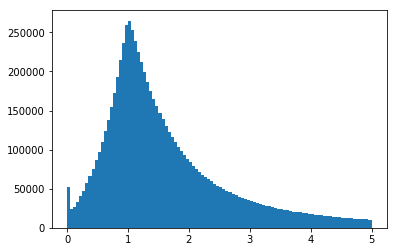

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(target[target < 5], 100)

In [0]:
Y[Y == 0].shape[0]/len(Y)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X[:300000], Y[:300000], test_size=0.5)
print (X_train.shape)
knn = KNeighborsClassifier(n_neighbors=15, weights='distance')
knn.fit(X_train, y_train) 
predictions = knn.predict(X_test)
print(classification_report(predictions, y_test))
print(accuracy_score(predictions, y_test))

(150000, 10)


/Users/alng/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys


             precision    recall  f1-score   support

          0       0.95      0.72      0.82    142312
          1       0.05      0.28      0.09      7688

avg / total       0.90      0.70      0.78    150000

0.701613333333


In [0]:
from sklearn.linear_model import LogisticRegression
X_train, X_test, y_train, y_test = train_test_split(X[:1300000], Y[:1300000], test_size=0.5)
print (X_train.shape)
lr = LogisticRegression(solver='sag')
lr.fit(X_train, y_train) 
predictions = lr.predict(X_test)
print(classification_report(predictions, y_test))
print(accuracy_score(predictions, y_test))

In [0]:
from sklearn import svm
sv = svm.SVC(kernel='linear', C = 1.0)
X_train, X_test, y_train, y_test = train_test_split(X[:300000], Y[:300000], test_size=0.5)
print (X_train.shape)
sv.fit(X_train, y_train) 
predictions = sv.predict(X_test)
print(classification_report(predictions, y_test))
print(accuracy_score(predictions, y_test))

(150000, 10)


/Users/alng/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


             precision    recall  f1-score   support

          0       1.00      0.72      0.84    150000
          1       0.00      0.00      0.00         0

avg / total       1.00      0.72      0.84    150000

0.72348


/Users/alng/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000)
X_train, X_test, y_train, y_test = train_test_split(X[:1000000], Y[:1000000], test_size=0.5)
print (X_train.shape)
rf.fit(X_train, y_train) 
predictions = rf.predict(X_test)
print(rf.feature_importances_)
print(classification_report(predictions, y_test))
print(accuracy_score(predictions, y_test))

(500000, 10)


/Users/alng/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
